# Analysis of NFL Play Choice: Tendencies & Play Call Prediction

## <font color=orange>Pre-analysis Steps</font>

### <font color=blue>Package Imports </font>

In [1]:
#primary packages for analysis and viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#packages for ML aspects
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

# packages for reporting
from scipy import stats
from scipy.stats import randint
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,roc_auc_score

#display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### <font color=blue>Read Data </font>

In [4]:
df = pd.read_csv("NFL Play by Play 2009-2018 (v5).csv")

C:\Users\pspat\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,lateral_receiver_player_id,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackl

### <font color=blue> Data Cleaning </font>

In [7]:
#filter out special team plays, extra points, plays with penalties, timeouts, etc
df=df.loc[(df['play_type'] == 'pass')|(df['play_type'] == 'run')]
df=df.loc[df["two_point_attempt"] == 0]
df=df.loc[df["timeout"] == 0] 
df=df.loc[df["extra_point_attempt"] == 0] 
df=df.loc[df["ydstogo"] > 0] 
df=df.loc[df["penalty"] == 0] 

In [8]:
#Team names change over time, applying necessary corrections
df.loc[df['posteam']=='JAC','posteam']='JAX'
df.loc[df['posteam']=='STL','posteam']='LAR'
df.loc[df['posteam']=='LA','posteam']='LAR'
df.loc[df['posteam']=='SD','posteam']='LAC'

#convert down from float to int
df['down']=df['down'].astype(int)

### <font color=blue> Dataframe Manipulation and Prep for Analysis and Modeling </font>

In [9]:
df_play_choice = df[['game_date','yardline_100', 'half_seconds_remaining','game_seconds_remaining','down','ydstogo','play_type','yards_gained','posteam','shotgun','score_differential','desc','td_team']]

#### check missing values and treat--in this case dropped all NAs due to low fraction of missing data

In [11]:
df_play_choice.td_team.fillna(0,inplace=True)
df_play_choice.isna().sum()

game_date                   0
yardline_100                0
half_seconds_remaining     17
game_seconds_remaining     14
down                        0
ydstogo                     0
play_type                   0
yards_gained              207
posteam                     0
shotgun                     0
score_differential          0
desc                        0
td_team                     0
dtype: int64

In [12]:
df_play_choice.dropna(inplace=True)

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
## add column for year--used for analysis purposes downstream
df_play_choice['year'] = df_play_choice['game_date'].apply(lambda x:x[:4])

## create new column for encoded play_type and posteam for modeling downstream
df_play_choice['play_type_encoded'] = df_play_choice['play_type'].apply(lambda x: 0 if x == 'run' else 1)
le = LabelEncoder()
df_play_choice['posteam_encoded'] = le.fit_transform(df_play_choice['posteam'])

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

## <font color=orange>Tendency Analysis (2008-2018 NFL Data)</font>

###  <font color=blue>Start with comparing broadly pass vs run play calling tendencies </font>

#### Pass vs Run across the league

Text(0, 0.5, 'Occurrences')

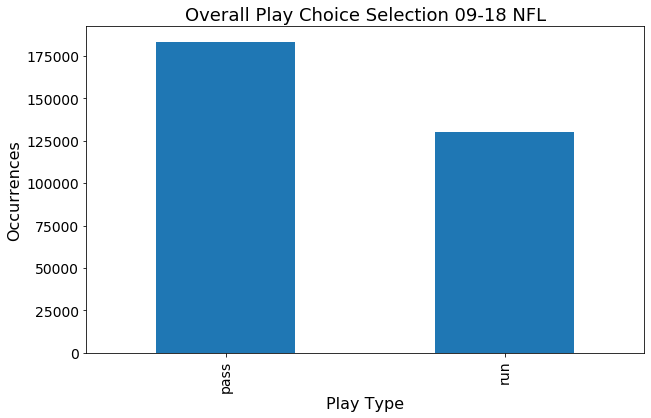

In [11]:
fig1=df_play_choice['play_type'].value_counts().plot(kind='bar', figsize = (10,6), fontsize=14)
plt.title('Overall Play Choice Selection 09-18 NFL', fontsize = 18)
plt.xlabel('Play Type',fontsize =16)
plt.ylabel('Occurrences', fontsize = 16)

In [19]:
# Average yards gained by play type
df_play_choice.groupby('play_type')['yards_gained'].mean()

play_type
pass    6.269083
run     4.336421
Name: yards_gained, dtype: float64

#### Pass vs Run by down across the league

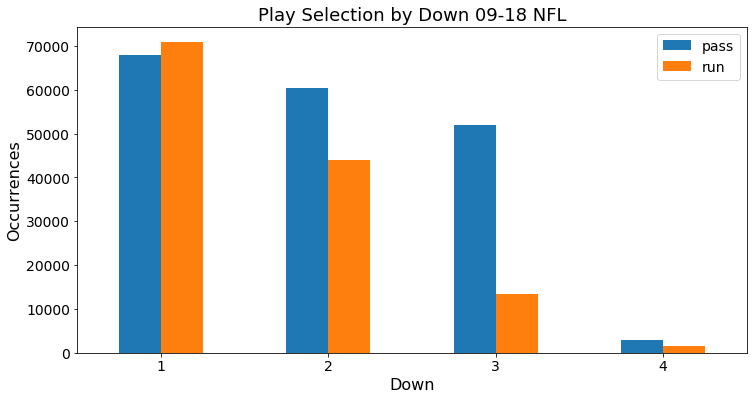

In [13]:
df_play_choice.groupby('down')['play_type'].value_counts().unstack(level=-1).plot(kind='bar',figsize=(12,6), fontsize= 14, rot = 0)
plt.xlabel('Down', fontsize=16)
plt.ylabel('Occurrences',fontsize = 16)
plt.title('Play Selection by Down 09-18 NFL', fontsize = 18)
plt.legend(fontsize = 14)

#### Pass vs Run by down and yards to go across the league

In [15]:
##Function to place an instance (play call) into a yards to go category
def ydstogo_grouping(row):
    if row['ydstogo'] in range(7,11):
        val = 3
    elif row['ydstogo'] in range(4,7):
        val = 2
    elif row['ydstogo'] in range(1,4):
        val = 1
    elif (row['ydstogo'] > 10) & (row['ydstogo'] < 20):
        val = 4 
    else:
        val = 5
    
    return val

In [16]:
#apply function on dataframe
df_play_choice['yds_to_go_grp'] = df_play_choice.apply(ydstogo_grouping, axis=1)

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.4, 0.45, 'Example for x-axis (2,3) represents 2nd down and yrd group 3,\n meaning 7-10 yards to go')

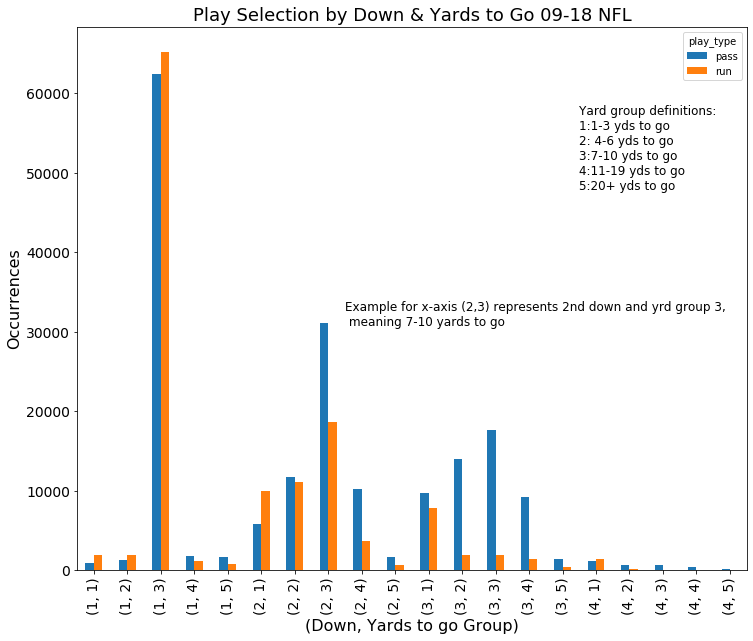

In [17]:
#generate plot
ax = df_play_choice.groupby(['down','yds_to_go_grp'])['play_type'].value_counts().unstack(level=-1).plot(kind='bar',figsize=(12,10),fontsize= 14, rot = 90)
plt.xlabel('(Down, Yards to go Group)', fontsize=16)
plt.ylabel('Occurrences', fontsize = 16)
plt.title('Play Selection by Down & Yards to Go 09-18 NFL', fontsize = 18)
plt.text(0.75,0.7,'Yard group definitions: \n1:1-3 yds to go\n2: 4-6 yds to go\n3:7-10 yds to go\n4:11-19 yds to go\n5:20+ yds to go',size = 12,transform=ax.transAxes)
plt.text(0.4,0.45,'Example for x-axis (2,3) represents 2nd down and yrd group 3,\n meaning 7-10 yards to go',size = 12,transform=ax.transAxes)

In [18]:
#tabulate results for better readability
yards_to_go_df = df_play_choice.groupby(['down','yds_to_go_grp'])['play_type'].value_counts().unstack(level=-1)
yards_to_go_df['pass_call_percent'] = yards_to_go_df['pass']/(yards_to_go_df['pass']+yards_to_go_df['run'])
yards_to_go_df['run_call_percent'] = yards_to_go_df['run']/(yards_to_go_df['pass']+yards_to_go_df['run'])

yards_to_go_df = yards_to_go_df.reset_index()
yards_to_go_df.columns.name = None
yards_to_go_df['yards_to_go']=yards_to_go_df['yds_to_go_grp'].apply(lambda x:'1-3' if x == 1 else('4-6' if x == 2 else('7-10' if x == 3 else('11-19' if x ==4 else '20+'))))

table_df =yards_to_go_df[['down','yards_to_go','pass_call_percent','run_call_percent']]
table_df=yards_to_go_df.set_index(['down','yards_to_go'])

format_dict = {'pass_call_percent': '{:.2%}','run_call_percent': '{:.2%}'}

table_df[['pass_call_percent','run_call_percent']].style.format(format_dict)

### <font color=blue>Analysis of play selection through time</font>

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Unrecognized location 'top left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


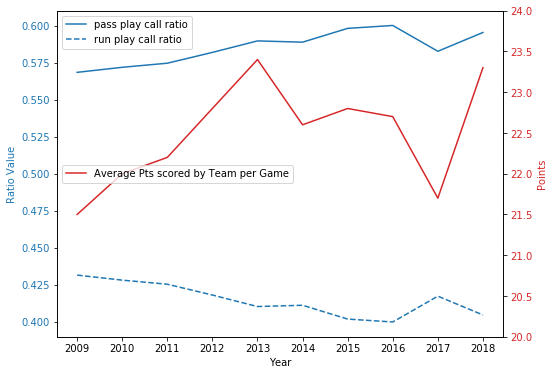

In [20]:
#group by year and calculate ratios
time_df = df_play_choice.groupby(['year','play_type_encoded']).count()['down']
time_df = time_df.unstack(level=-1)
time_df['pass_ratio']= time_df[1]/(time_df[1]+time_df[0])
time_df['run_ratio']= time_df[0]/(time_df[1]+time_df[0])

#load in scoring data to overlay
df_yearly_scoring = pd.read_csv('yearly_scoring_nfl.csv')
df_yearly_scoring.drop(index = 0, inplace = True)
df_yearly_scoring.set_index('Year', inplace=True)
df_yearly_scoring.sort_index(inplace=True)
scoring_series = df_yearly_scoring['Avg Pts per Team']
scoring_series = list(scoring_series)
time_df['avg_pts_per_team'] = scoring_series

#plot
fig, ax1 = plt.subplots(figsize=(8, 6))
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Ratio Value', color=color)
ax1.plot(time_df.index,time_df['pass_ratio'],color = color, label= 'pass play call ratio')
ax1.plot(time_df.index,time_df['run_ratio'], color = color, linestyle = 'dashed', label='run play call ratio')
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Points', color=color)
ax2.plot(time_df.index,time_df['avg_pts_per_team'], color=color,label= 'Average Pts scored by Team per Game')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([20,24])

ax1.legend(loc='top left')
ax2.legend(loc='center left')

### <font color=blue>Analysis of play direction</font>

In [21]:
df_play_choice['direction'] = ['right' if 'right' in ele else 'left' if 'left' in ele else 'middle' if 'middle' in ele else 'other' for ele in df_play_choice['desc']]
df_play_dir = df_play_choice[df_play_choice['direction'] != 'other']

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


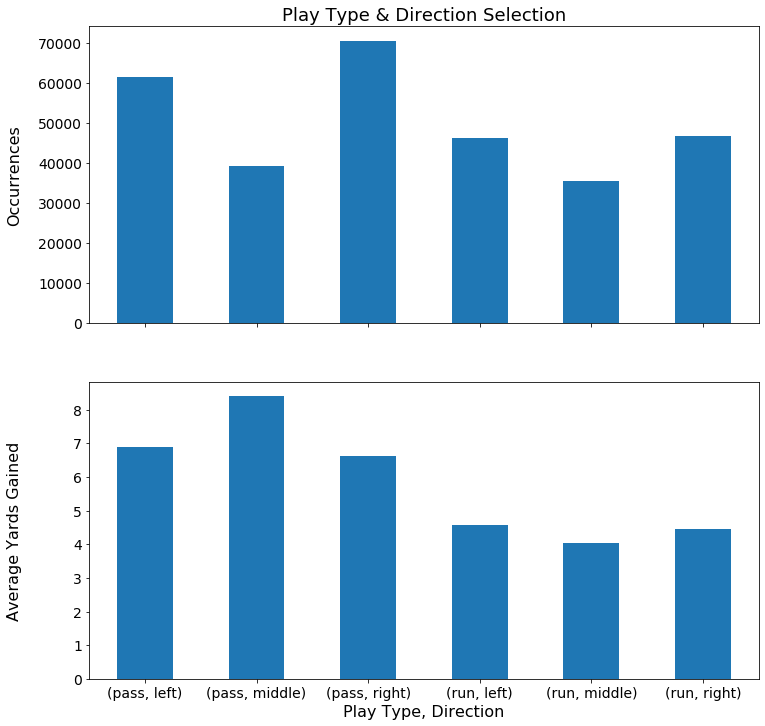

In [22]:
fig, axes = plt.subplots(nrows=2,
                         ncols=1,
                         sharex=True,figsize=(12,12))

df_play_dir.groupby(['play_type','direction'])['yards_gained'].count().plot(kind='bar', fontsize= 14, rot = 0, ax=axes[0])

axes[0].set_ylabel('Occurrences',fontsize = 16)
axes[0].set_title('Play Type & Direction Selection', fontsize = 18)

df_play_dir.groupby(['play_type','direction'])['yards_gained'].mean().plot(kind='bar', fontsize= 14, rot = 0, ax=axes[1])
axes[1].set_ylabel('Average Yards Gained',fontsize = 16)
axes[1].set_xlabel('Play Type, Direction', fontsize=16)

axes[0].get_yaxis().set_label_coords(-0.1,0.5)
axes[1].get_yaxis().set_label_coords(-0.1,0.5)

#### Analysis of how well each team spreads the ball around the field (2018 only)

In [23]:
df_play_dir_18 = df_play_dir[df_play_dir['year'] == '2018'] 
team_dir_df_18 = df_play_dir_18.groupby(['play_type','direction','posteam'])['yards_gained'].count().unstack(level=1)
team_dir_df_18['mid_rat'] = team_dir_df_18['middle']/(team_dir_df_18['middle']+team_dir_df_18['left']+team_dir_df_18['right'])
team_dir_df_18['left_rat'] = team_dir_df_18['left']/(team_dir_df_18['middle']+team_dir_df_18['left']+team_dir_df_18['right'])
team_dir_df_18['right_rat'] = team_dir_df_18['right']/(team_dir_df_18['middle']+team_dir_df_18['left']+team_dir_df_18['right'])
team_dir_df_18

direction          left  middle  right   mid_rat  left_rat  right_rat
play_type posteam                                                    
pass      ARI       180      93    191  0.200431  0.387931   0.411638
          ATL       237     142    209  0.241497  0.403061   0.355442
          BAL       129     184    190  0.365805  0.256461   0.377734
          BUF       168      63    210  0.142857  0.380952   0.476190
          CAR       180      96    218  0.194332  0.364372   0.441296
          CHI       142     117    216  0.246316  0.298947   0.454737
          CIN       177     123    210  0.241176  0.347059   0.411765
          CLE       169      98    231  0.196787  0.339357   0.463855
          DAL       200      82    204  0.168724  0.411523   0.419753
          DEN       179      84    222  0.173196  0.369072   0.457732
          DET       181     128    221  0.241509  0.341509   0.416981
          GB        241      99    226  0.174912  0.425795   0.399293
          HOU       151     110    158  0.262530  0.360382   0.377088
          IND       204     142    231  0.246101  0.353553   0.400347
          JAX       148     142    223  0.276803  0.288499   0.434698
          KC        177     106    242  0.201905  0.337143   0.460952
          LAC       157     123    185  0.264516  0.337634   0.397849
          LAR       207     136    204  0.248629  0.378428   0.372943
          MIA       148     109    173  0.253488  0.344186   0.402326
          MIN       181     113    241  0.211215  0.338318   0.450467
          NE        220     138    190  0.251825  0.401460   0.346715
          NO        178      91    201  0.193617  0.378723   0.427660
          NYG       199     107    229  0.200000  0.371963   0.428037
          NYJ       182      98    202  0.203320  0.377593   0.419087
          OAK       194     134    191  0.258189  0.373796   0.368015
          PHI       194      94    257  0.172477  0.355963   0.471560
          PIT       202     205    197  0.339404  0.334437   0.326159
          SEA       156      86    137  0.226913  0.411609   0.361478
          SF        182     136    165  0.281573  0.376812   0.341615
          TB        217     152    196  0.269027  0.384071   0.346903
          TEN       167      99    133  0.248120  0.418546   0.333333
          WAS       177     134    159  0.285106  0.376596   0.338298
run       ARI        56     196     71  0.606811  0.173375   0.219814
          ATL       164      12    127  0.039604  0.541254   0.419142
          BAL       142      94    195  0.218097  0.329466   0.452436
          BUF       144     135    158  0.308924  0.329519   0.361556
          CAR       101     130    119  0.371429  0.288571   0.340000
          CHI       183      61    150  0.154822  0.464467   0.380711
          CIN       127      73    121  0.227414  0.395639   0.376947
          CLE       153      42    180  0.112000  0.408000   0.480000
          DAL       152     117    137  0.288177  0.374384   0.337438
          DEN        92     126    107  0.387692  0.283077   0.329231
          DET       141     116     99  0.325843  0.396067   0.278090
          GB        125      88     98  0.282958  0.401929   0.315113
          HOU       130     118    153  0.294264  0.324190   0.381546
          IND       109     145     92  0.419075  0.315029   0.265896
          JAX        99     203     85  0.524548  0.255814   0.219638
          KC         81     139    112  0.418675  0.243976   0.337349
          LAC       134     110    112  0.308989  0.376404   0.314607
          LAR       151      84    137  0.225806  0.405914   0.368280
          MIA       123     111     96  0.336364  0.372727   0.290909
          MIN       114      85     93  0.291096  0.390411   0.318493
          NE        145     131    118  0.332487  0.368020   0.299492
          NO        143      58    228  0.135198  0.333333   0.531469
          NYG       121      99     94  0.315287  0.385350   0.299363
          

In [24]:
#take the range of above ratios.  E.g. the max ratio - min ratio.  So for ARI above .4116-.2004
result = []
for i in range(len(team_dir_df_18)):
    result.append(max(team_dir_df_18['mid_rat'][i],team_dir_df_18['right_rat'][i],team_dir_df_18['left_rat'][i])-min(team_dir_df_18['mid_rat'][i],team_dir_df_18['right_rat'][i],team_dir_df_18['left_rat'][i]))
team_dir_df_18['range_of_rat'] = result  

In [25]:
pass_range_ratio=team_dir_df_18['range_of_rat']['pass'].sort_values()
run_range_ratio=team_dir_df_18['range_of_rat']['run'].sort_values()
average_range_of_ratio = []
for i in range(len(pass_range_ratio)):
    average_range_of_ratio.append(((team_dir_df_18['range_of_rat']['pass']+team_dir_df_18['range_of_rat']['run'])/2))
    
average_range_of_ratio =pd.Series(average_range_of_ratio[0])

team_ball_spread_df = pd.concat([pass_range_ratio,run_range_ratio,average_range_of_ratio], keys=['pass_range_ratio','run_range_ratio','pass-run_avg_range_ratio'],axis=1)
team_ball_spread_df.sort_values(by='pass-run_avg_range_ratio')

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


,pass_range_ratio,run_range_ratio,pass-run_avg_range_ratio
PIT,0.013245,0.136943,0.075094
TB,0.115044,0.077810,0.096427
OAK,0.115607,0.077381,0.096494
LAC,0.133333,0.067416,0.100375
HOU,0.114558,0.087282,0.100920
SF,0.095238,0.106771,0.101004
TEN,0.170426,0.046729,0.108578
NE,0.149635,0.068528,0.109081
MIA,0.148837,0.081818,0.115328
SEA,0.184697,0.053648,0.119172


In [26]:
#Final table for blog
team_dir_df_18['middle_percent'] = team_dir_df_18['middle']/(team_dir_df_18['middle']+team_dir_df_18['left']+team_dir_df_18['right'])
team_dir_df_18['left_percent'] = team_dir_df_18['left']/(team_dir_df_18['middle']+team_dir_df_18['left']+team_dir_df_18['right'])
team_dir_df_18['right_percent'] = team_dir_df_18['right']/(team_dir_df_18['middle']+team_dir_df_18['left']+team_dir_df_18['right'])
team_dir_df_18.columns.name = None
format_dict = {'left_percent': '{:.2%}','middle_percent': '{:.2%}','right_percent': '{:.2%}'}
pc_ratios_df=team_dir_df_18[['left_percent','middle_percent','right_percent']]
pc_ratios_df=pc_ratios_df.unstack(level=0)

#### Table of ratios for play type and direction by team for blog

In [27]:
pc_ratios_df

left_percent           middle_percent           right_percent  \
play_type         pass       run           pass       run          pass   
posteam                                                                   
ARI           0.387931  0.173375       0.200431  0.606811      0.411638   
ATL           0.403061  0.541254       0.241497  0.039604      0.355442   
BAL           0.256461  0.329466       0.365805  0.218097      0.377734   
BUF           0.380952  0.329519       0.142857  0.308924      0.476190   
CAR           0.364372  0.288571       0.194332  0.371429      0.441296   
CHI           0.298947  0.464467       0.246316  0.154822      0.454737   
CIN           0.347059  0.395639       0.241176  0.227414      0.411765   
CLE           0.339357  0.408000       0.196787  0.112000      0.463855   
DAL           0.411523  0.374384       0.168724  0.288177      0.419753   
DEN           0.369072  0.283077       0.173196  0.387692      0.457732   
DET           0.341509  0.396067       0.241509  0.325843      0.416981   
GB            0.425795  0.401929       0.174912  0.282958      0.399293   
HOU           0.360382  0.324190       0.262530  0.294264      0.377088   
IND           0.353553  0.315029       0.246101  0.419075      0.400347   
JAX           0.288499  0.255814       0.276803  0.524548      0.434698   
KC            0.337143  0.243976       0.201905  0.418675      0.460952   
LAC           0.337634  0.376404       0.264516  0.308989      0.397849   
LAR           0.378428  0.405914       0.248629  0.225806      0.372943   
MIA           0.344186  0.372727       0.253488  0.336364      0.402326   
MIN           0.338318  0.390411       0.211215  0.291096      0.450467   
NE            0.401460  0.368020       0.251825  0.332487      0.346715   
NO            0.378723  0.333333       0.193617  0.135198      0.427660   
NYG           0.371963  0.385350       0.200000  0.315287      0.428037   
NYJ           0.377593  0.283333       0.203320  0.338889      0.419087   
OAK           0.373796  0.357143       0.258189  0.360119      0.368015   
PHI           0.355963  0.385294       0.172477  0.344118      0.471560   
PIT           0.334437  0.273885       0.339404  0.315287      0.326159   
SEA           0.411609  0.354077       0.226913  0.345494      0.361478   
SF            0.376812  0.367188       0.281573  0.263021      0.341615   
TB            0.384071  0.371758       0.269027  0.334294      0.346903   
TEN           0.418546  0.350467       0.248120  0.345794      0.333333   
WAS           0.376596  0.331536       0.285106  0.245283      0.338298   

                     
play_type       run  
posteam              
ARI        0.219814  
ATL        0.419142  
BAL        0.452436  
BUF        0.361556  
CAR        0.340000  
CHI        0.380711  
CIN        0.376947  
CLE        0.480000  
DAL        0.337438  
DEN        0.329231  
DET        0.278090  
GB         0.315113  
HOU        0.381546  
IND        0.265896  
JAX        0.219638  
KC         0.337349  
LAC        0.314607  
LAR        0.368280  
MIA        0.290909  
MIN        0.318493  
NE         0.299492  
NO         0.531469  
NYG        0.299363  
NYJ        0.377778  
OAK        0.282738  
PHI        0.270588  
PIT        0.410828  
SEA        0.300429  
SF         0.369792  
TB         0.293948  
TEN        0.303738  
WAS        0.423181

#### Heatmap of the same ratios for better readability

Text(0.5, 1, 'Team-wise Heatmap of Play Call Tendency (Type and Direction)')

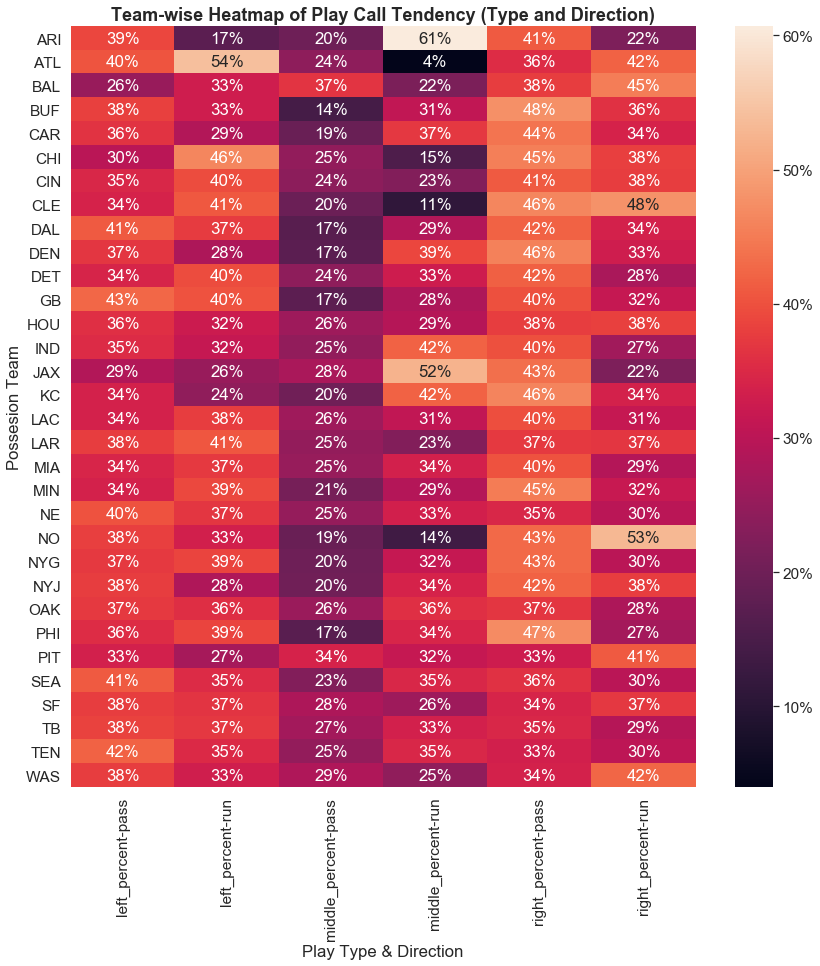

In [82]:
plt.figure(figsize=(14,14))
from matplotlib.ticker import FuncFormatter
fmt = lambda x,pos: '{:.0%}'.format(x)
sns.heatmap(pc_ratios_df, annot=True, fmt='.0%',cbar_kws={'format': FuncFormatter(fmt)})
plt.xlabel('Play Type & Direction')
plt.ylabel('Possesion Team')
plt.title('Team-wise Heatmap of Play Call Tendency (Type and Direction)',fontsize=18,weight='bold')

## <font color=orange>Predicting the play (pass or run) selection at any time (league wide)</font>

#### Prep dataset--train with data from 2015-2017, test on 2018 data

In [48]:
df_plays_15_17 = df_play_choice[df_play_choice['game_date'].str.contains('2015|2016|2017')]
df_plays_18 = df_play_choice[df_play_choice['game_date'].str.contains('2018')]

X_train = df_plays_15_17[['yardline_100', 'half_seconds_remaining','down','ydstogo','score_differential','posteam_encoded','shotgun']]
y_train = df_plays_15_17['play_type_encoded']

#### Train model (hyper params chosen based on a grid search like that a few blocks below)

In [32]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(colsample_bytree=0.6,learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=3,n_estimators=300,subsample=0.7,)
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

#### Test model performance on held out test set

In [33]:
X_test  = df_plays_18[['yardline_100', 'half_seconds_remaining','down','ydstogo','score_differential','posteam_encoded','shotgun']]
y_actual = df_plays_18['play_type_encoded']
y_pred = xgb_classifier.predict(X_test)

print(classification_report(y_actual,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65     11710
           1       0.76      0.80      0.78     17237

    accuracy                           0.73     28947
   macro avg       0.72      0.71      0.71     28947
weighted avg       0.72      0.73      0.72     28947



#### Generate feature importance plot

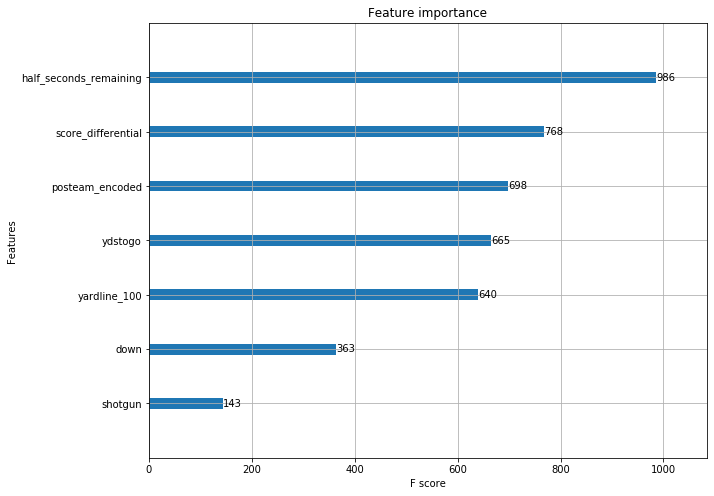

In [34]:
import matplotlib
fig, ax = plt.subplots(figsize = (10,8))
xgb.plot_importance(xgb_classifier,ax=ax)
matplotlib.rcParams.update({'font.size': 22})

#### check out train set F1 score as sanity check

In [35]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(xgb_classifier, X_train, y_train, scoring='f1', cv = 5))

[0.78592375 0.78195359 0.78392873 0.78395792 0.78166762]


#### grid search for best params

In [36]:
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,roc_auc_score
from sklearn.model_selection import KFold

clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': [100,200,300],
              'learning_rate': [0.01,0.05,0.1,0.5,1.0],
              'subsample': [0.3,0.5,0.6,0.7,0.9],
              'max_depth': [3,4,5,6,8],
              'colsample_bytree': [0.5,0.6,0.7,0.8,0.9],
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 5
kfold_5 = KFold(n_splits= numFolds, shuffle = True)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 25,
                         scoring = 'accuracy', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  3.7min finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   error_score=0,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logisti...
                   iid='warn', n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'lear

In [37]:
y_pred = clf.predict(X_test)
print(classification_report(y_actual,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.62      0.65     11710
           1       0.75      0.79      0.77     17237

    accuracy                           0.72     28947
   macro avg       0.71      0.71      0.71     28947
weighted avg       0.72      0.72      0.72     28947



In [38]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=4, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

### Try a Neural Net as well

In [49]:
from sklearn.neural_network import MLPClassifier

In [50]:
nn_clf = MLPClassifier()

In [51]:
nn_clf.fit(X_train,y_train)
y_pred_nn = nn_clf.predict(X_test)
print(classification_report(y_actual,y_pred_nn))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65     11710
           1       0.77      0.74      0.75     17237

    accuracy                           0.71     28947
   macro avg       0.70      0.70      0.70     28947
weighted avg       0.71      0.71      0.71     28947



In [75]:
nn_clf = MLPClassifier()
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,),(30,60,30)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs','sgd', 'adam'],
    'alpha': [0.0001,0.001,0.01],
    'learning_rate': ['constant','adaptive'],
}

numFolds = 5
kfold_5 = KFold(n_splits= numFolds, shuffle = True)

clf_nn_cv = RandomizedSearchCV(nn_clf, 
                         param_distributions = parameter_space,
                         cv = kfold_5,  
                         n_iter = 25,
                         scoring = 'f1', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf_nn_cv.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 19.7min finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   error_score=0,
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_iter=200, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_m...
                                           verbose=False, warm_start=False),
                   iid='warn', n_iter=25, n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu'],
  

In [76]:
clf_nn_cv.best_estimator_

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30, 60, 30), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [77]:
y_pred = clf_nn_cv.predict(X_test)
print(classification_report(y_actual,y_pred))

              precision    recall  f1-score   support

           0       0.62      0.73      0.67     11710
           1       0.79      0.69      0.74     17237

    accuracy                           0.71     28947
   macro avg       0.70      0.71      0.70     28947
weighted avg       0.72      0.71      0.71     28947



## <font color=orange>Player Level Analysis: Peyton Manning's Impact on the Broncos</font>

In [52]:
df_den = df_play_choice[df_play_choice['posteam']=='DEN'] 

In [53]:
df_den['year'] = df_den['year'].astype(int)
df_den = df_den[df_den['year']<2015]
df_den.year.value_counts()

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


2012    1124
2013    1118
2014    1027
2010    1005
2011     987
2009     919
Name: year, dtype: int64

In [54]:
df_den['peyton_flag'] = np.where(df_den['year']<2012, 'Before Peyton', 'With Peyton')

In [55]:
df_den.groupby('peyton_flag').mean()['yards_gained']

peyton_flag
Before Peyton    5.285812
With Peyton      6.184460
Name: yards_gained, dtype: float64

In [56]:
df_den.groupby('peyton_flag').sum()['yards_gained']

peyton_flag
Before Peyton    15387.0
With Peyton      20217.0
Name: yards_gained, dtype: float64

In [58]:
tmp = df_den.groupby('year').sum()['yards_gained']

In [60]:
num_games_per_seasons = 16
den_yards_per_year = tmp/num_games_per_seasons
den_yards_per_year

year
2009    299.1875
2010    351.0625
2011    311.4375
2012    408.5000
2013    454.5625
2014    400.5000
Name: yards_gained, dtype: float64

In [64]:
matplotlib.rcParams.update({'font.size': 12})

No handles with labels found to put in legend.


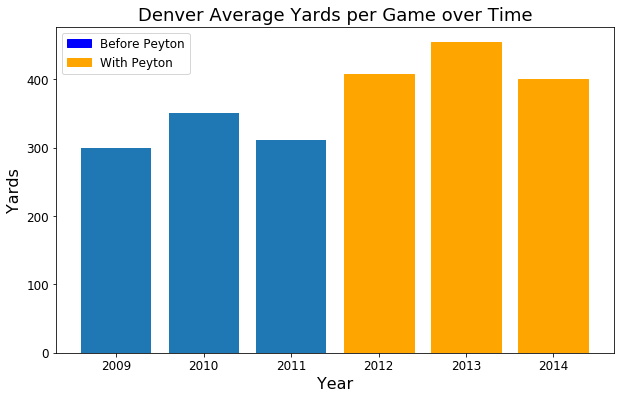

In [68]:
import matplotlib.patches as mpatches
plt.figure(figsize=(10,6))
barlist = plt.bar(den_yards_per_year.index,den_yards_per_year)
barlist[3].set_color('orange')
barlist[4].set_color('orange')
barlist[5].set_color('orange')
plt.title('Denver Average Yards per Game over Time',fontsize = 18)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Yards',fontsize=16)
plt.legend(fontsize = 14)
bl_patch = mpatches.Patch(color='blue', label='Before Peyton')
oj_patch = mpatches.Patch(color='orange', label='With Peyton')
plt.legend(handles=[bl_patch,oj_patch])

In [69]:
df_den_td = df_den[df_den['td_team']=='DEN']

In [70]:
den_tds = df_den_td.groupby('peyton_flag').count()['td_team']

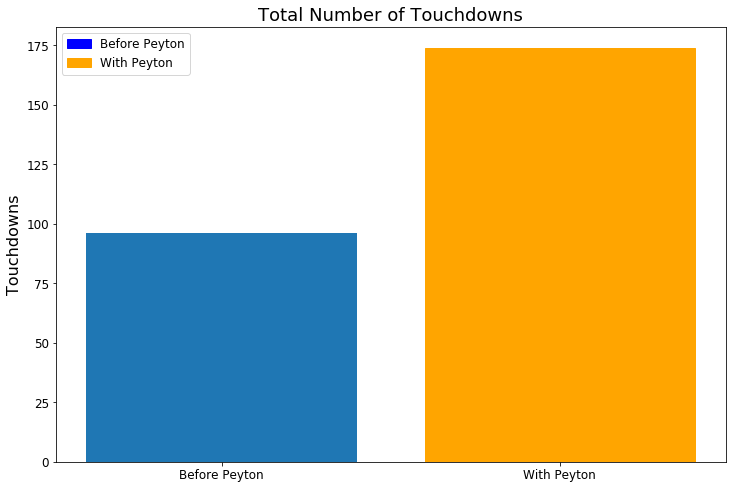

In [73]:
plt.figure(figsize=(12,8))
plt.ylabel('Touchdowns',fontsize=16)
plt.title('Total Number of Touchdowns',fontsize=18)
barlist = plt.bar(den_tds.index,den_tds)
barlist[1].set_color('orange')
bl_patch = mpatches.Patch(color='blue', label='Before Peyton')
oj_patch = mpatches.Patch(color='orange', label='With Peyton')
plt.legend(handles=[bl_patch,oj_patch])